In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
from statsmodels.tsa.arima.model import ARIMA 
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.functional as F
from torch import optim
from sklearn.decomposition import PCA

sys.path.append('../')

from BasicAutoEncoder.model import Encoder, Decoder, AutoEncoder, SelfAttentionEncoder
from Andreini_data.data import load_y

## Implementing the MCMC procedure as proposed by Andreini 
We consider the model
$$
\mathbf{\mathbb{f}}_t = G(\mathbf{y}_t) \\ 
\mathbf{y}_t = F(\mathbf{\mathbb{f}}_t) + \mathbf{\varepsilon}_t \\ 
\mathbf{\mathbb{f}}_t = \mathbf{B}_1 \mathbf{f}_{t-1} + \cdots + \mathbf{B}_p \mathbf{f}_{t-p} + \mathbf{u}_t \\
\mathbf{\varepsilon}_t = \mathbf{\Phi_1} \mathbf{\varepsilon}_{t-1} + \cdots \mathbf{\Phi_d} \mathbf{\varepsilon}_{t-d} + \mathbf{\epsilon}_t 
$$


In [110]:
class ArProcess():
    """
    class containing the autoregressive processes of the idiosyncratic error terms \varepsilon_t
    This should be a var process if Q can be nondiagonal
    """
    def __init__(self, T:int, n:int, d:int):
        self.n = n
        self.T = T 
        self.d = d #number of lags
        self.parameters = None
        x = np.zeros((T,n)) #start with empty data
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[:,i]) for i in range(x.shape[1])]


    def fit(self, x):
        self.models = [ARIMA(order=(self.d,0,0), trend='n', endog=x[:,i]) for i in range(x.shape[1])]
        self.fitted = [mod.fit(method='yule_walker') for mod in self.models]
        return self

    @property
    def coefficients(self):
        """
        Return estimated coefficients of the ar() processes
        """
        return np.stack([_.params[0] for _ in phi.fitted])
    
    def sigma2(self):
        """
        Return estimated residual sigma_2 of the processes
        """
        return np.stack([_.params[1] for _ in phi.fitted])

    def conditionalExpectation(self):
        """
        obtain Phi(L)eps_t
        """
        return np.stack([mod.predict() for mod in self.fitted]).T
    
    def initialize(self):
        for mod in self.models:
            mod.initialize_stationary()
            
    def simulate(self):
        return np.stack([mod.simulate(nsimulations=self.T) for mod in self.fitted]).T

In [3]:
n = 10
T = 100
eps = np.random.normal(size = (T,n))
print(eps.shape)
ar = ArProcess(T,n,1)
ar.fit(eps)
pred = ar.conditionalExpectation()
print(pred.shape)
sim = ar.simulate()
sim.shape

(100, 10)
(100, 10)


(100, 10)

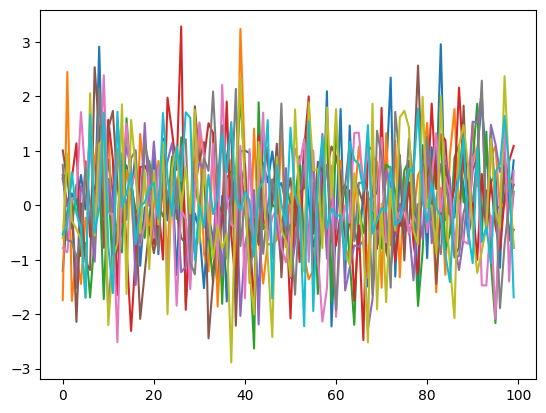

In [4]:
#plt.plot(eps.T);
plt.plot(sim);

In [110]:
mu = np.array([0,0,0,90,990,1,1])
sig = np.array([1,1,1,1,1,1,1])
np.random.multivariate_normal(mu, np.diag(sig), size=(10)).shape

(10, 7)

In [16]:
# A step-up version where error terms epsilon_t are iid instead of ar process
def check_convergence(loss_hist: list, eps = 1e-10):
    if len(loss_hist) < 11:
        return False
    if len(loss_hist) > 8000:
        return True
    return ((np.array(loss_hist)[-11:-1] - np.array(loss_hist)[-10:]) < eps).all()

def init_eps(T:int,n:int):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    eps = np.random.normal(size = (T,n))
    return eps, np.mean(eps,axis=0), np.var(eps, axis=0)

def d2FMMCMC_iid(y: np.ndarray, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module):
    n = y.shape[1]
    T = y.shape[0]
    eps, mu_eps, sigma_eps = init_eps(T,n)
    convergence = False

    hist_keys = ['loss', 'eps', 'mu_eps', 'var_eps']
    train_hist = {k: [] for k in hist_keys}

    y_tensor = torch.from_numpy(y).float()
    i = 0
    while not convergence:
        y_tilde = y - mu_eps
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde + np.random.multivariate_normal(mu_eps, np.diag(sigma_eps), size=(T))
            optimizer.zero_grad()
            model_in = torch.from_numpy(y_tilde_mc).float()
            out = model(model_in)
            loss  = criterion(out, model_in)
            loss.backward()
            optimizer.step()
            train_hist['loss'].append(loss.item())
        eps = y - model(y_tensor).detach().numpy()
        sigma_eps = np.var(eps, axis=0)
        mu_eps = np.mean(eps,axis=0)
        train_hist['eps'].append(eps)
        train_hist['mu_eps'].append(mu_eps)
        train_hist['var_eps'].append(sigma_eps)
        print(i, train_hist['loss'][-1], end='\r')
        i+=1
        convergence = check_convergence(train_hist['loss'])
    return model, train_hist

In [24]:
y = load_y()
input_dim = y.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, 80, 50, factor_dim], activation=nn.Tanh()) 
dec = Decoder(hidden_dim = [factor_dim, 100, input_dim], activation=nn.Tanh())
model = AutoEncoder(enc, dec)
model, train_hist = d2FMMCMC_iid(y=y, model=model, n_epoch=1, optimizer = optim.Adam(params=model.parameters(),lr=0.01), criterion= nn.MSELoss())

0.004353163866326213


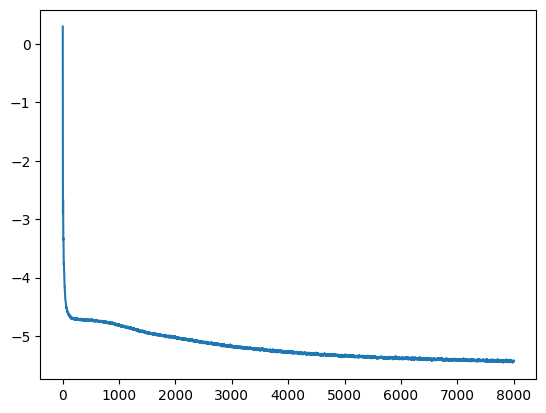

In [25]:
print(np.mean(train_hist['loss'][-50:]))
plt.plot(np.log(np.array(train_hist['loss'])))

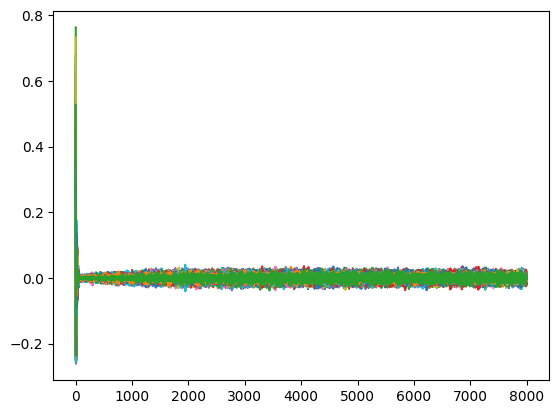

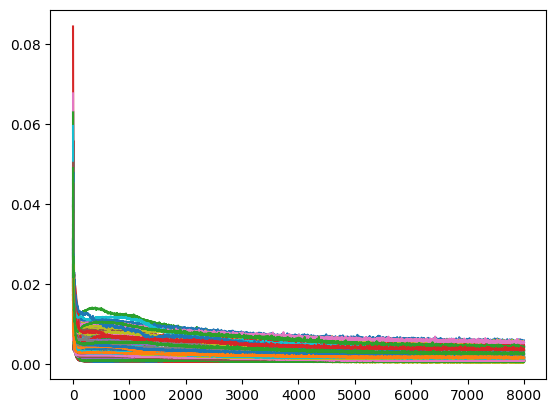

In [26]:
plt.plot(np.array(train_hist['mu_eps']));
plt.figure()
plt.plot(np.array(train_hist['var_eps']));

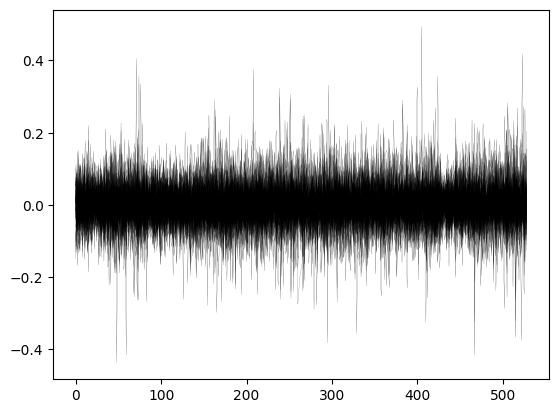

In [20]:
plt.plot(train_hist['eps'][-1], alpha = 1, color='black', linewidth=0.1);

Text(0.5, 1.0, 'principal components')

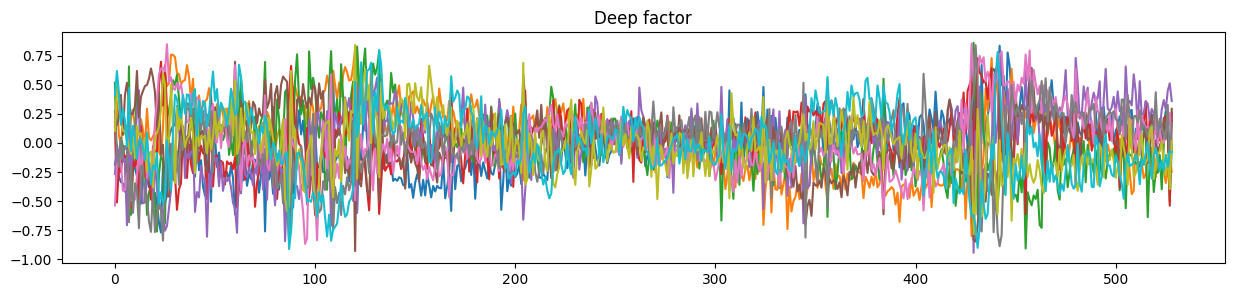

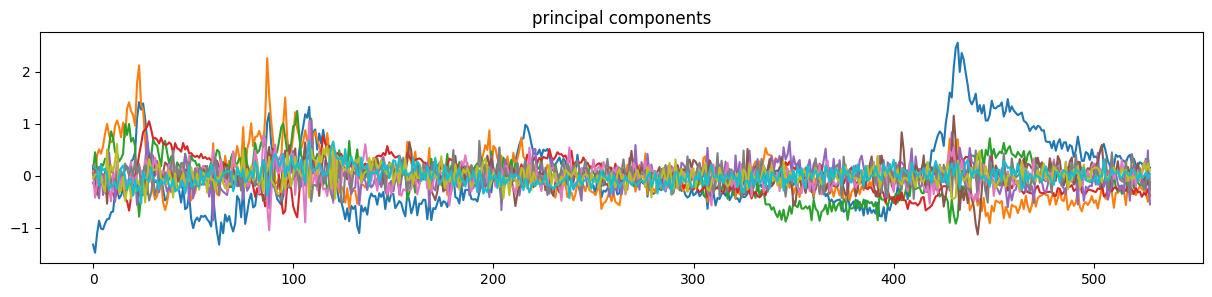

In [21]:
#plot factors
y_tensor = torch.from_numpy(y).float()
plt.figure(figsize=(15,3))
plt.plot(model.enc(y_tensor).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=factor_dim)
pc = pca.fit_transform(y)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('principal components')

Text(0.5, 1.0, '$\\hat y$')

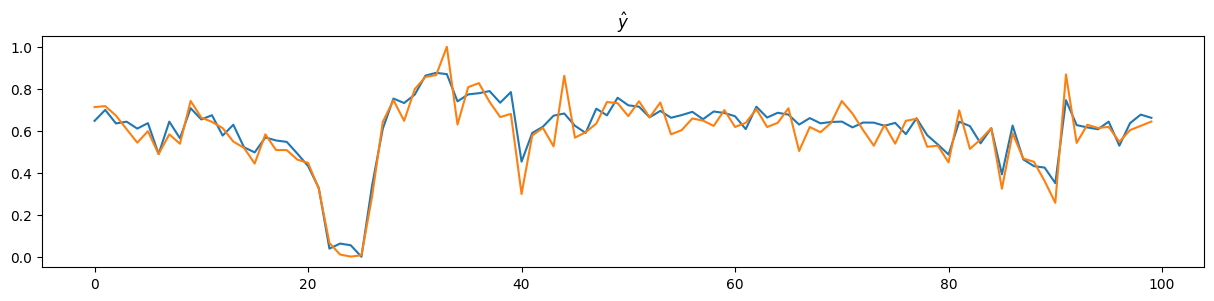

In [22]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(y_tensor).detach().numpy()
i = 100
plt.plot(y_hat[0:100,i]);
plt.plot(y[0:100,i])
plt.title('$\hat y$')

In [114]:
def init_eps(T:int,n:int):
    """
    Initinitalize idiosyncratic error terms.
    """
    #TODO: How to do this lol?
    return np.random.normal(size = (T,n))

def check_convergence(loss_hist: list, eps = 1e-10):
    if len(loss_hist) < 11:
        return False
    if len(loss_hist) > 1000:
        return True
    return ((np.array(loss_hist)[-11:-1] - np.array(loss_hist)[-10:]) < eps).all()

def d2FMMCMC(y: np.ndarray, model: AutoEncoder, n_epoch:int, optimizer: optim.Optimizer, criterion: nn.Module):
    n = y.shape[1]
    T = y.shape[0]
    eps = init_eps(T,n)
    phi = ArProcess(T,n,d=1).fit(eps)
    convergence = False
    hist_keys = ['loss', 'coeff', 'sigma2']
    train_hist = {k: [] for k in hist_keys}    
    y_tensor = torch.from_numpy(y).float()
    i = 0
    while not convergence:
        train_hist['coeff'].append(phi.coefficients)
        train_hist['sigma2'].append(phi.sigma2)

        y_tilde = y - phi.conditionalExpectation()
        for epoch in range(n_epoch):
            y_tilde_mc = y_tilde+phi.simulate()

            optimizer.zero_grad()
            model_in = torch.from_numpy(y_tilde_mc).float()
            out = model(model_in)
            loss  = criterion(out, model_in)
            loss.backward()
            optimizer.step()
            train_hist['loss'].append(loss.item())
        eps = y - model(y_tensor).detach().numpy()
        phi = ArProcess(T,n,d=1).fit(eps)
        print(i, train_hist['loss'][-1], end='\r')
        i+=1
        convergence = check_convergence(train_hist['loss'])
    return phi, model, train_hist

## Test on the data

In [119]:
y = load_y()
input_dim = y.shape[1]
factor_dim = 10
enc = Encoder(hidden_dim = [input_dim, 50, factor_dim], activation=nn.Tanh()) #fully linear
dec = Decoder(hidden_dim = [factor_dim, 50, input_dim])
model = AutoEncoder(enc, dec)
phi, model, train_hist = d2FMMCMC(y=y, model=model, n_epoch=5, optimizer = optim.Adam(params=model.parameters(),lr=0.01), criterion= nn.MSELoss())

KeyboardInterrupt: 

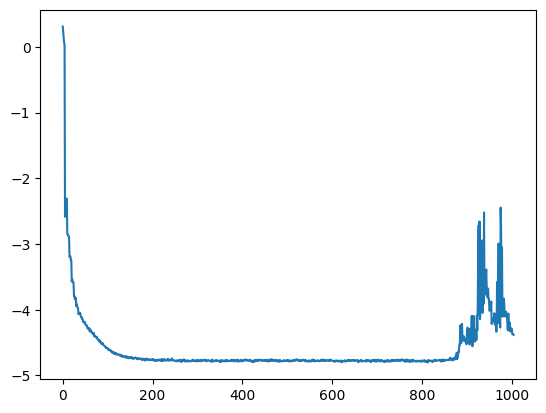

In [ ]:
plt.plot(np.log(np.array(train_hist['loss'])))

Text(0.5, 1.0, 'principal components')

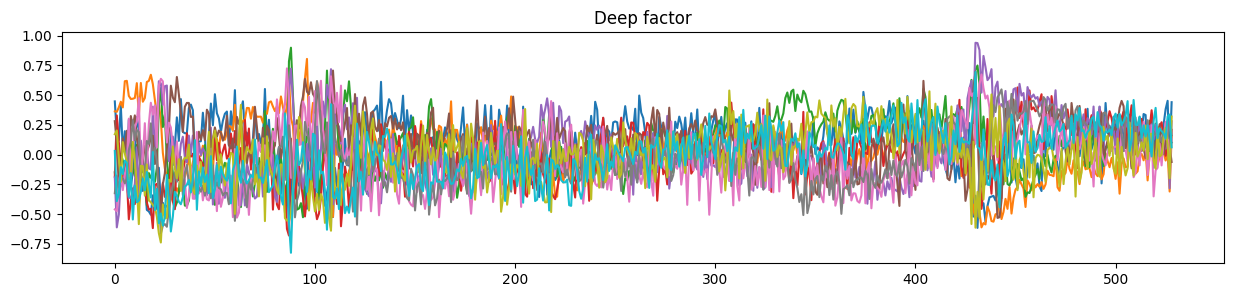

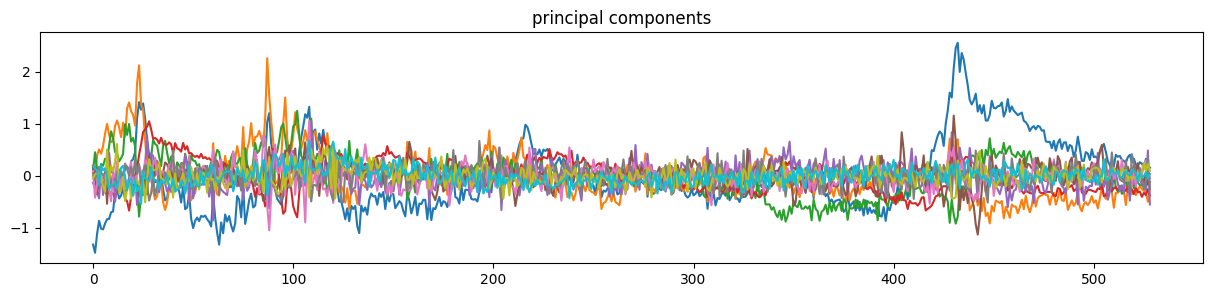

In [31]:
#plot factors
y_tensor = torch.from_numpy(y).float()
plt.figure(figsize=(15,3))
plt.plot(model.enc(y_tensor).detach().numpy());
plt.title('Deep factor')

#compare to PCA
pca = PCA(n_components=factor_dim)
pc = pca.fit_transform(y)
plt.figure(figsize=(15,3))
plt.plot(pc);
plt.title('principal components')

Text(0.5, 1.0, '$\\hat y$')

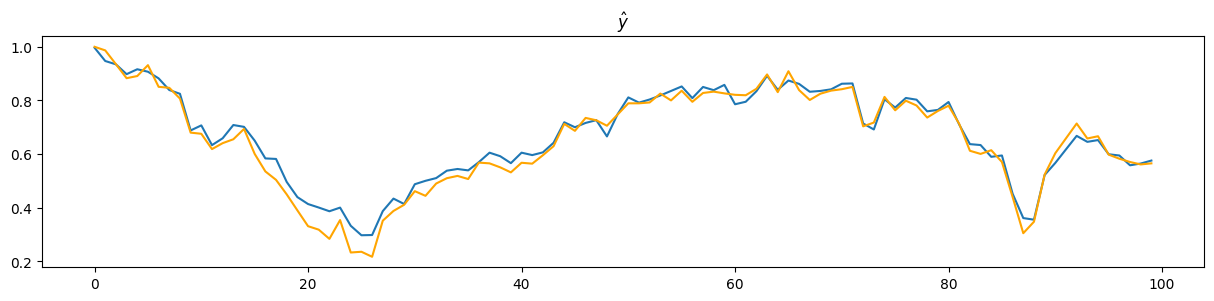

In [92]:
#plot reconstructed y_hat
plt.figure(figsize=(15,3))
y_hat = model(y_tensor).detach().numpy()
i = i+1
plt.plot(y_hat[0:100,i]);
plt.plot(y[0:100,i],c='orange')
plt.title('$\hat y$')